In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import MSELoss
import os, sys
# os.chdir("..")
sys.path.append(os.path.join(os.getcwd().split("KAMemory")[0], "KAMemory/src"))
import models as models
import utils as utils
import main as main
from logger import logger

from tqdm import tqdm
from scipy.ndimage import convolve1d

%load_ext autoreload
%autoreload

logger(".")

2025-05-08 20:28:29 | .


**General Settings**

In [2]:
np.random.seed(11)

network_params = {}

network_params["mec_N_x"] = 50
network_params["mec_N_y"] = 1
network_params["dim_mec"] = network_params["mec_N_x"]*network_params["mec_N_y"]
network_params["mec_sigma"] = 4
network_params["dim_lec"] = 50
network_params["num_cues"] = 2
NUM_CUES = network_params["num_cues"]

network_params["bias"] = False

network_params["dim_ei"] = network_params["dim_mec"] + network_params["dim_lec"]
network_params["dim_ca3"] = 1000
network_params["dim_ca1"] = 1000
network_params["dim_eo"] = network_params["dim_ei"]

network_params["K_lec"] = 5
network_params["K_ei"] = 10
network_params["K_ca3"] = 15
network_params["K_ca1"] = 15
network_params["K_eo"] = network_params["K_ei"]

network_params["beta_ei"] = 150
network_params["beta_ca3"] = 150
network_params["beta_ca1"] = 150
network_params["beta_eo"] = network_params["beta_ei"]

""" track parameters """
track_params = {}
track_params["length"] = network_params["mec_N_x"]
track_params["num_laps"] = 100
track_params["reward"] = "random"
track_params["cue"] = "random"
NUM_LAPS = track_params["num_laps"]

logger()

2025-05-08 20:28:29 | 


# experiment 1 | two positions two cues

### run

**Autoencoder & data**

In [3]:
""" make data """

num_train_stimuli = 500
num_test_stimuli = 500

training_samples, _, _ = utils.sparse_stimulus_generator_sensory(
                                                num_stimuli=num_train_stimuli,
                                                K=network_params["K_lec"],
                                                mec_size=network_params["dim_mec"],
                                                lec_size=network_params["dim_lec"],
                                                N_x=network_params["mec_N_x"],
                                                N_y=network_params["mec_N_y"],
                                                pf_sigma=network_params["mec_sigma"],
                                                lap_length=track_params["length"],
                                                num_laps=None,#track_params["num_laps"],
                                                num_cues=None,#network_params["num_cues"],
                                                position_list=None,
                                                cue_positions=None,
                                                sen_list=None,
                                                plot=False)

test_samples, _, _ = utils.sparse_stimulus_generator_sensory(
                                                num_stimuli=num_test_stimuli,
                                                K=network_params["K_lec"],
                                                mec_size=network_params["dim_mec"],
                                                lec_size=network_params["dim_lec"],
                                                N_x=network_params["mec_N_x"],
                                                N_y=network_params["mec_N_y"],
                                                pf_sigma=network_params["mec_sigma"],
                                                lap_length=track_params["length"],
                                                num_laps=None,#track_params["num_laps"],
                                                num_cues=None,#network_params["num_cues"],
                                                position_list=None,
                                                cue_positions=None,
                                                sen_list=None,
                                                plot=False)
logger()

2025-05-08 20:28:29 | 


In [4]:
""" autoencoder """

info, autoencoder = models.load_session(
    idx=3, verbose=True)


out_ae, latent_ae = utils.reconstruct_data(
                                data=training_samples,
                                num=10,
                                model=autoencoder,
                                show=False, 
                                plot=False)


2025-05-08 20:28:29 | loading idx=3, cache_dir='/Users/daniekru/Research/lab/KAMemory/cache' cache_dir_2='/Users/daniekru/Research/lab/KAMemory/src/cache' os.getcwd()='/Users/daniekru/Research/lab/KAMemory/notebooks'
2025-05-08 20:28:29 | Pre-selected session: [3]
2025-05-08 20:28:29 | bias=False
/Users/daniekru/Research/lab/KAMemory/src/models.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization

{'date': '14/10/2024 19:03:10',
 'epochs': 4000,
 'loss_ae': 0.00197,
 'network_params': {'K_ca1': 15,
                    'K_ca3': 15,
                    'K_ei': 10,
                    'K_eo': 10,
                    'K_lec': 5,
                    'alpha': 0.5,
                    'beta_ca1': 150,
                    'beta_ca3': 150,
                    'beta_ei': 150,
                    'beta_eo': 150,
                    'bias': False,
                    'dim_ca1': 1000,
                    'dim_ca3': 1000,
                    'dim_ei': 100,
                    'dim_eo': 100,
                    'dim_lec': 50,
                    'dim_mec': 50,
                    'mec_N_x': 50,
                    'mec_N_y': 1,
                    'mec_sigma': 4,
                    'num_cues': 2},
 'num_stimuli': 2000}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1555.64it/s]


In [5]:
""" initialization """
network_params["alpha"] = 0.5
alpha_baseline = 0.1
network_params["num_cues"] = 2
track_params["cue_position"] = [10, 30]
track_params["num_laps"] = 100


track_train_input, lap_cues, alpha_samples = utils.get_track_input(track_params=track_params,
                                                             network_params=network_params,
                                                             cue_duration=1)
logger(f"shape: {track_train_input.shape} {lap_cues.shape}")

2025-05-08 20:28:29 | shape: (5000, 100) (100,)


In [6]:
""" make model """
W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(
                                                        bias=network_params["bias"])

model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=network_params["dim_ca3"],
            K_lat=network_params["K_ca1"],
            K_out=network_params["K_eo"],
            K_ca3=network_params["K_ca3"],
            beta=network_params["beta_ca1"],
            alpha=network_params["alpha"],
            identity_IS=False,
            random_IS=False)

""" run """
_, model = utils.testing_mod(data=track_train_input,
                       model=model,
                       alpha_samples=alpha_samples,
                       alpha_baseline=alpha_baseline,
                       column=True)

logger()

2025-05-08 20:28:29 | testing...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 495.61it/s]
2025-05-08 20:28:39 | 


### analysis

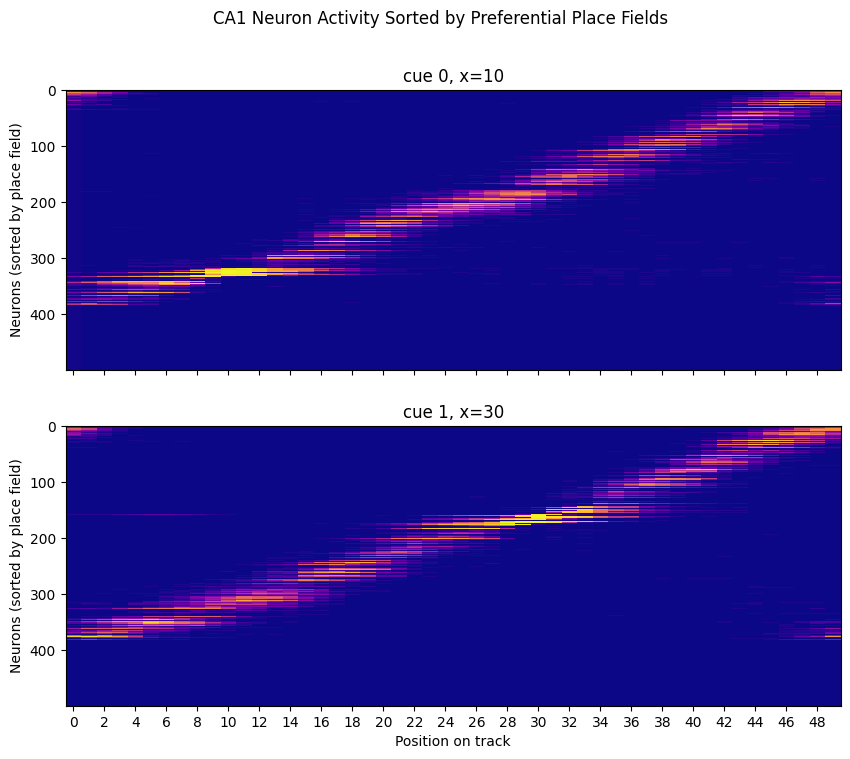

In [7]:
""" plot """
name="ca1"
activity = np.array(model.recordings[name]).reshape((track_params["num_laps"],
                                                     track_params["length"], -1))


# Assuming 'activity' is a 3D array of shape (laps, positions, neurons)
# activity.shape = (n_laps, n_positions, n_neurons)



# Step 4: Plot the heatmap
_, axs = plt.subplots(network_params["num_cues"], 1, 
                      figsize=(10, 4*network_params["num_cues"]),
                      sharex=True)
plt.suptitle(f'{name.upper()} Neuron Activity Sorted by Preferential Place Fields')

h=2
for k, ax in enumerate(axs):
    # Step 1: Average across laps (axis 0) for a given cue
    activity_mean = np.mean(activity[np.where(lap_cues==k)[0]], axis=0)  # Now shape is (positions, neurons)
    
    # Step 2: Find preferential place field (position with max activity) for each neuron
    preferential_fields = np.argmax(activity_mean, axis=0)  # Finds the max position for each neuron
    # Step 3: Sort neurons by preferential place fields in descending order
    sorted_indices = np.argsort(preferential_fields)[::-1]  # Sort in descending order of place fields
    sorted_activity = activity_mean[:, sorted_indices]  # Reorder neurons by sorted indices

    ax.imshow(sorted_activity.T[:500], aspect='auto', cmap='plasma', interpolation='nearest', vmin=0)
    #ax.colorbar(label='Activity (Averaged over laps)')
    ax.set_ylabel('Neurons (sorted by place field)')
    ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
    ax.set_title(f"cue {k}, x={track_params['cue_position'][k]}")
ax.set_xlabel('Position on track')
plt.show()


**Plot**

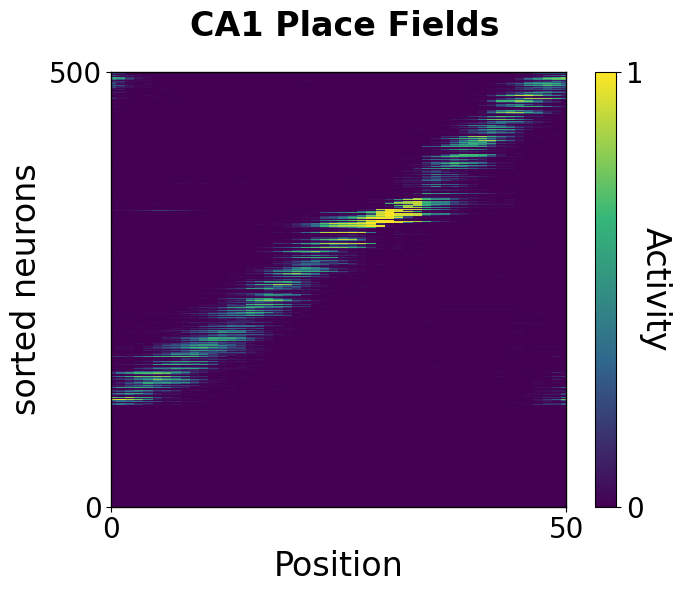

In [8]:
# Set up the figure and axis
fig_e, ax = plt.subplots(figsize=(7, 6))

# Create a custom colormap similar to viridis
colors = ['#440154', '#30678D', '#35B778', '#FDE724']
cmap = LinearSegmentedColormap.from_list('custom_viridis', colors)

# Create the heatmap
cax = ax.imshow(sorted_activity.T[:500], aspect='auto', 
                cmap=cmap, interpolation='nearest', 
                vmin=0, vmax=1.)

# Customize the colorbar
cbar = fig_e.colorbar(cax, ax=ax, ticks=[0, 1])
cbar.set_label('Activity', fontsize=24,
               rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=20)

# Set labels and title
ax.set_ylabel('sorted neurons', fontsize=24)
ax.set_xlabel('Position', fontsize=24)
fig_e.suptitle("CA1 Place Fields", fontsize=24, fontweight='bold')

# Customize x-axis
ax.set_xticks([0, 49])
ax.set_xticklabels([0, 50], fontsize=20)
ax.set_xlim((0, 49))

# Customize y-axis
ax.set_yticks([0, 499])
ax.set_yticklabels([500, 0], fontsize=20)
ax.set_ylim((499, 0))  # Flip the y-axis to have 0 at the top

# Add a grid
ax.grid(True, linestyle=':', alpha=0.7)

# Add a border to the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Adjust layout and display
plt.tight_layout()
plt.show()

#### CA1 sorting

In [9]:
# all activity of IS
K_HIGHEST = 10
NUM_CUES = network_params["num_cues"]

# average activity of each neuron
avg_activities = []
laps_data = {region: {cue : {} for cue in range(NUM_CUES)} for region in model.recordings.keys()}
# {'x_ei': {0: {}, 1: {}}, 'ca1': {0: {}, 1: {}}}
for cue in range(NUM_CUES):
  cue_pos = track_params['cue_position'][cue]
  for region, value in model.recordings.items():
    if region != "W_ca3_ca1":
      activity = np.array(model.recordings[region]).reshape((track_params["num_laps"],
                                                  track_params["length"], -1))
      activity_av_laps_positions = np.mean(activity, axis=(0, 1))
      activity_av_when_cue = np.mean(activity[np.where(lap_cues==cue)[0]], axis=0)
      sensitivity = activity_av_when_cue[cue_pos]/ activity_av_laps_positions[cue_pos]
      laps_data[region][cue]["activity"] = activity_av_when_cue
      laps_data[region][cue]["sensitivity"] = sensitivity
      laps_data[region][cue]["k-th"] = np.argsort(sensitivity)[-K_HIGHEST:] # [..]


neurons_cue_1_position_1 = np.argsort(laps_data["IS"][0]["activity"][track_params["cue_position"][0]])[-K_HIGHEST:]
neurons_cue_2_position_1 = np.argsort(laps_data["IS"][1]["activity"][track_params["cue_position"][0]])[-K_HIGHEST:]
neurons_cue_1_position_2 = np.argsort(laps_data["IS"][0]["activity"][track_params["cue_position"][1]])[-K_HIGHEST:]
neurons_cue_2_position_2 = np.argsort(laps_data["IS"][1]["activity"][track_params["cue_position"][1]])[-K_HIGHEST:]

neurons_cue_1 = neurons_cue_1_position_1[~np.isin(neurons_cue_1_position_1, neurons_cue_2_position_1)]
neurons_cue_2 = neurons_cue_2_position_2[~np.isin(neurons_cue_2_position_2, neurons_cue_1_position_2)]

selective_neurons = np.concatenate((neurons_cue_1, neurons_cue_2))

logger()

/var/folders/77/b66qkr5d21l_3nnw6f563fw80000gp/T/ipykernel_86224/4198438652.py:17: RuntimeWarning: divide by zero encountered in divide
  sensitivity = activity_av_when_cue[cue_pos]/ activity_av_laps_positions[cue_pos]
/var/folders/77/b66qkr5d21l_3nnw6f563fw80000gp/T/ipykernel_86224/4198438652.py:17: RuntimeWarning: invalid value encountered in divide
  sensitivity = activity_av_when_cue[cue_pos]/ activity_av_laps_positions[cue_pos]
2025-05-08 20:28:39 | 


2025-05-08 20:28:39 | (100, 50, 1000)


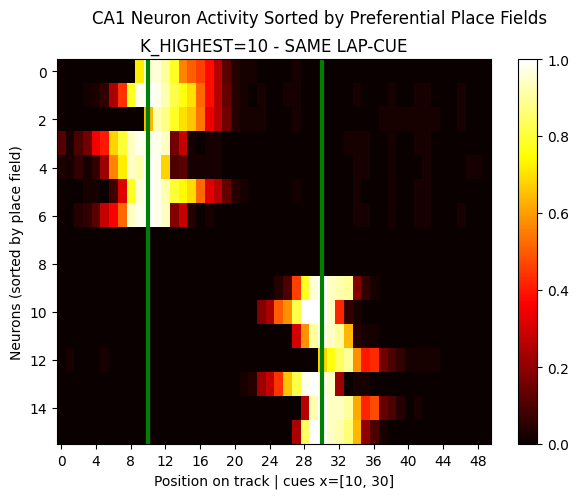

In [10]:
""" POSITION-a CUE-a """

# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{ca1_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros((network_params["mec_N_x"], network_params["dim_ca1"]))  # (pos, neurons)
for k in range(NUM_CUES):
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]],
                           axis=0)
    #activity_cue = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    index_neurons = neurons_cue_1 if k == 0 else neurons_cue_2
    
    # select according to IS idxs
    ca1_a[:, len(index_neurons)*k: len(index_neurons)*(k+1)] = activity_cue[:, index_neurons]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'CA1 Neuron Activity Sorted by Preferential Place Fields')

cax = ax.imshow(ca1_a.T[:len(selective_neurons)], aspect='auto', cmap='hot', interpolation='nearest', 
          vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
h=4
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=} - SAME LAP-CUE")

for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3)
plt.show()

2025-05-08 20:28:40 | (100, 50, 1000)


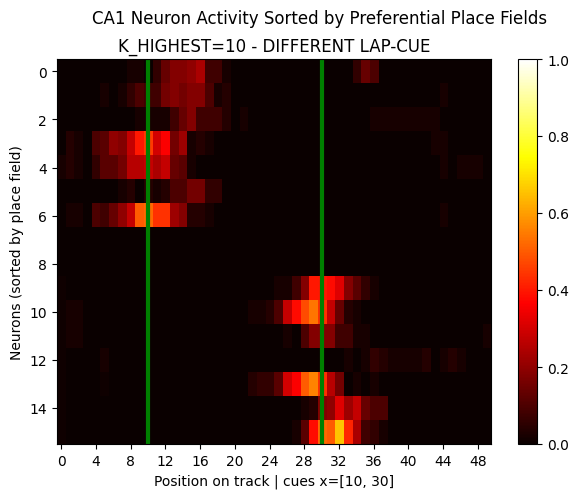

In [11]:
""" POSITION-a CUE-b """

# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{ca1_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros((network_params["mec_N_x"], network_params["dim_ca1"]))  # (pos, neurons)
for k in range(NUM_CUES):
    #activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]], axis=0)
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    index_neurons = neurons_cue_1 if k == 0 else neurons_cue_2
    
    # select according to IS idxs
    ca1_a[:, len(index_neurons)*k: len(index_neurons)*(k+1)] = activity_cue[:, index_neurons]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'CA1 Neuron Activity Sorted by Preferential Place Fields')

cax = ax.imshow(ca1_a.T[:len(selective_neurons)], aspect='auto', 
                cmap='hot', interpolation='nearest', 
          vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
h=4
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
ax.set_title(f"{K_HIGHEST=} - DIFFERENT LAP-CUE")

for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3)
plt.show()

2025-05-08 20:28:40 | (100, 50, 1000)


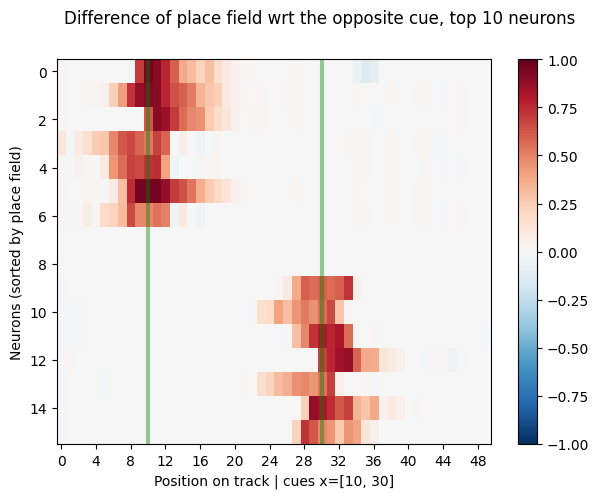

In [12]:
""" DIFFERENCE """

# all activity of ca1
ca1_activity = np.array(model.recordings["ca1"]).reshape((track_params["num_laps"],
                                                          track_params["length"], -1))
logger(f"{ca1_activity.shape}")


# average activity of each neuron
ca1_a = np.zeros((network_params["mec_N_x"], network_params["dim_ca1"]))  # (pos, neurons)
for k in range(NUM_CUES):
    activity_cue = np.mean(ca1_activity[np.where(lap_cues==k)[0]], axis=0)
    activity_cue_2 = np.mean(ca1_activity[np.where(lap_cues==((k+1)%NUM_CUES))[0]], axis=0)

    # select according to IS idxs
    #ca1_a[:, K_HIGHEST*k:K_HIGHEST*(k+1)] = activity_cue[:, is_laps_data[k]["k-th"]] - \
    #    activity_cue_2[:, is_laps_data[k]["k-th"]]

    index_neurons = neurons_cue_1 if k == 0 else neurons_cue_2
    
    # select according to IS idxs
    ca1_a[:, len(index_neurons)*k: len(index_neurons)*(k+1)] = activity_cue[:, index_neurons] - \
        activity_cue_2[:, index_neurons]

    #ca1_a[:, K_HIGHEST*1:K_HIGHEST*(1+1)] = activity_cue[:, is_laps_data[1]["k-th"]]


# plotting
fig, ax = plt.subplots(1, 1, 
                      figsize=(7, 5),
                      sharex=True)
plt.suptitle(f'Difference of place field wrt the opposite cue, top {K_HIGHEST} neurons')

cax = ax.imshow(ca1_a.T[:len(selective_neurons)], aspect='auto', cmap='RdBu_r', interpolation='nearest', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax)
#ax.colorbar(label='Activity (Averaged over laps)')
ax.set_ylabel('Neurons (sorted by place field)')
h=4
ax.set_xticks(range(0, track_params["length"], h), range(0, track_params["length"], h))
ax.set_xlabel(f"Position on track | cues x={track_params['cue_position']}")
#ax.set_title(f"K={K_HIGHEST=} - DIFFERENCE LAP-CUE")

for cuex in track_params['cue_position']:
    ax.axvline(cuex, color="green", lw=3, alpha=0.4)
plt.show()

In [13]:
""" settings """
labsize = 34
titlesize = 34
ticksize = 24

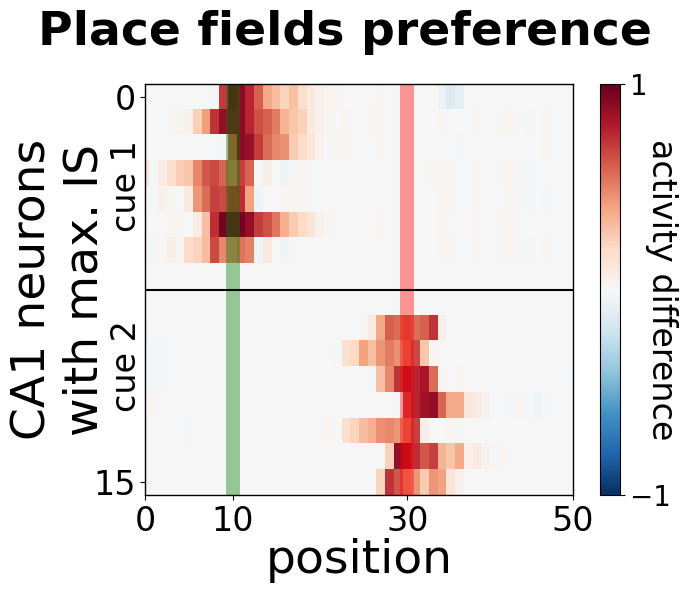

In [14]:
fig_f, ax_f = plt.subplots(figsize=(7, 6))

cax_f = ax_f.imshow(ca1_a.T[:len(selective_neurons)], aspect='auto', cmap='RdBu_r', 
               interpolation='nearest', vmin=-1, vmax=1)

# colorbar
cbar_f = fig_f.colorbar(cax_f, ax=ax_f, ticks=[-1, 1])
cbar_f.set_label('activity difference', fontsize=24,
               rotation=270, labelpad=5)
cbar_f.ax.tick_params(labelsize=20)

# labels & title
#ax_f.set_ylabel(f'top selective\nneurons', fontsize=labsize, labelpad=-20)
ax_f.set_ylabel(f'CA1 neurons\nwith max. IS', fontsize=labsize, labelpad=-10)
ax_f.set_xlabel(f"position", fontsize=labsize, labelpad=0)
fig_f.suptitle("Place fields preference", fontsize=titlesize, fontweight='bold')

# Customize x-axis
ax_f.set_xticks([0, track_params['cue_position'][0],
                 track_params['cue_position'][1], 49])
ax_f.set_xticklabels([0, track_params['cue_position'][0],
                      track_params['cue_position'][1], 50], fontsize=ticksize)
ax_f.set_xlim((0, 49))

# Customize y-axis
ax_f.set_yticks([0, 15])
ax_f.set_yticklabels([0, 15], fontsize=ticksize)
ax_f.set_ylim((15.5, -0.5))

# identification lines
ax_f.axvline(track_params['cue_position'][0], color="green", lw=10, alpha=0.4)
ax_f.axvline(track_params['cue_position'][1], color="red", lw=10, alpha=0.4)
ax_f.axhline(7.5, color="black")

#
ax_f.text(-4, 5, f"cue 1", rotation=90, fontsize=24)
ax_f.text(-4, 12, f"cue 2", rotation=90, fontsize=24)


# Add a border to the plot
for spine in ax_f.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

#ax.text(0.5, -0.20, f"Cues at x={track_params['cue_position']}", 
#        horizontalalignment='center', verticalalignment='top', 
#        transform=ax.transAxes, fontsize=15)

plt.tight_layout()
plt.show()

# experiment II | two positions one cue

In [15]:
""" initialization """
network_params["alpha"] = 0.5
alpha_baseline = 0.1
network_params["num_cues"] = 1
cue_positions = [10, 30]
track_params["cue_position"] = [cue_positions[0]]
track_params["num_laps"] = 100


track_train_input1, lap_cues, alpha_samples = utils.get_track_input(track_params=track_params,
                                                              network_params=network_params,
                                                              cue_duration=1)
track_params["cue_position"] = [cue_positions[1]]
track_train_input2, lap_cues, alpha_samples = utils.get_track_input(track_params=track_params,
                                                             network_params=network_params,
                                                             cue_duration=1)

logger(f"shape: {track_train_input.shape} {lap_cues.shape}")

2025-05-08 20:28:40 | shape: (5000, 100) (100,)


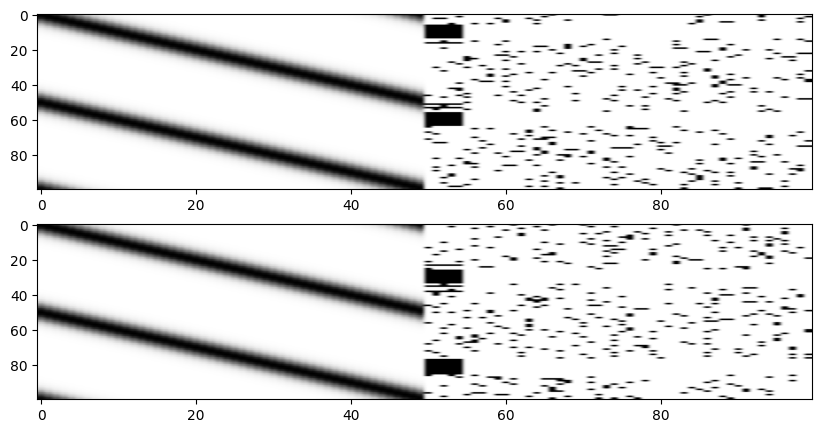

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.imshow(track_train_input1[:100], aspect='auto', cmap="Greys")
plt.subplot(212)
plt.imshow(track_train_input2[:100], aspect='auto', cmap="Greys")
plt.show()

**run**

In [17]:
""" make model """
W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(
                                                        bias=network_params["bias"])

model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=network_params["dim_ca3"],
            K_lat=network_params["K_ca1"],
            K_out=network_params["K_eo"],
            K_ca3=network_params["K_ca3"],
            beta=network_params["beta_ca1"],
            alpha=network_params["alpha"],
            identity_IS=False,
            random_IS=False)

""" run1 """
out1, model = utils.testing_mod(data=track_train_input1,
                       model=model,
                       alpha_samples=alpha_samples,
                       alpha_baseline=alpha_baseline,
                       column=True)
logger(f"test1={out1}")
name="ca1"
activity1 = np.array(model.recordings[name]).reshape((track_params["num_laps"],
                                                     track_params["length"], -1))
wca3ca1_1 = model.W_ca3_ca1.detach().numpy().copy()
weica1_1 = model.W_ei_ca1.detach().numpy().copy()
weica3_1 = model.W_ei_ca3.detach().numpy().copy()
logger.debug(f"{weica1_1.mean()=}")

""" run2 """
model.reset()
out2, model = utils.testing_mod(data=track_train_input2,
                       model=model,
                       alpha_samples=alpha_samples,
                       alpha_baseline=alpha_baseline,
                       column=True)
logger(f"test2={out2}")
name="ca1"
activity2 = np.array(model.recordings[name]).reshape((track_params["num_laps"],
                                                      track_params["length"], -1))
wca3ca1_2 = model.W_ca3_ca1.detach().numpy().copy()
weica1_2 = model.W_ei_ca1.detach().numpy().copy()

weica3_2 = model.W_ei_ca3.detach().numpy().copy()
logger.debug(f"{weica1_1.mean()=} - {weica1_2.mean()=}")
logger()

2025-05-08 20:28:40 | testing...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 455.17it/s]
2025-05-08 20:28:51 | test1=0.07001780718564987
2025-05-08 20:28:51 | weica1_1.mean()=np.float32(0.0011023077)
2025-05-08 20:28:52 | testing...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 530.52it/s]
2025-05-08 20:29:02 | test2=0.06811466813087463
2025-05-08 20:29:02 | weica1_1.mean()=np.float32(0.0011023077) - weica1_2.mean()=np.float32(0.0011023077)
2025-05-08 20:29:02 | 


#### plot tuning

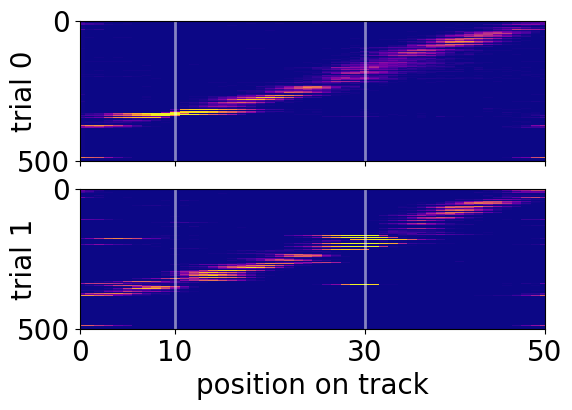

In [19]:
# --- trial 1
# Step 1: Average across laps (axis 0) for a given cue
activity_mean_1 = np.mean(activity1[np.where(lap_cues==0)[0]], axis=0)  # Now shape is (positions, neurons)
# Step 2: Find preferential place field (position with max activity) for each neuron
preferential_fields_1 = np.argmax(activity_mean_1, axis=0)  # Finds the max position for each neuron
# Step 3: Sort neurons by preferential place fields in descending order
sorted_indices_1 = np.argsort(preferential_fields_1)[::-1]  # Sort in descending order of place fields
sorted_activity_1 = activity_mean_1[:, sorted_indices_1]  # Reorder neurons by sorted indices

# --- trial 2
# Step 1: Average across laps (axis 0) for a given cue
activity_mean_2 = np.mean(activity2[np.where(lap_cues==0)[0]], axis=0)  # Now shape is (positions, neurons)
# Step 2: Find preferential place field (position with max activity) for each neuron
preferential_fields_2 = np.argmax(activity_mean_2, axis=0)  # Finds the max position for each neuron
# Step 3: Sort neurons by preferential place fields in descending order
sorted_activity_2 = activity_mean_2[:, sorted_indices_1]  # Reorder neurons by sorted indices

""" plot """

fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
fontsize=20

# --- 1
axs[0].imshow(sorted_activity_1.T[:500], aspect='auto', cmap='plasma', interpolation='nearest', vmin=0)

# --- 2
axs[1].imshow(sorted_activity_2.T[:500], aspect='auto', cmap='plasma', interpolation='nearest', vmin=0)
axs[1].set_xticks([0, 10, 30, 49], [0, 10, 30, 50], fontsize=fontsize)
axs[1].set_xlabel('position on track', fontsize=fontsize)

# ---
for i, ax in enumerate(axs):
    ax.set_ylabel(f'trial {i}', labelpad=-15, fontsize=fontsize)
    ax.set_xlim(0, 49)
    ax.set_yticks([0, 500], [0, 500], fontsize=fontsize)
    ax.axvline(10, lw=2, color='white', alpha=0.5)
    ax.axvline(30, lw=2, color='white', alpha=0.5)

plt.show()


#### plot comparison in/out

In [20]:
# indexes of the spatial neurons
idx1 = np.where(activity1[:, 10, :].mean(axis=0) > 0.001)[0]
idx2 = np.where(activity2[:, 10, :].mean(axis=0) > 0.001)[0]

idx1_ = np.where(activity1[:, 10, :].mean(axis=0) <= 0.001)[0]
idx2_ = np.where(activity2[:, 10, :].mean(axis=0) <= 0.001)[0]
idx1.shape, idx2.shape, idx1_.shape, idx2_.shape

((24,), (99,), (976,), (901,))

In [22]:
""" activity """
activity_dot_in = utils.cosine_similarity_mat(activity1.mean(axis=0)[:, idx1], activity2.mean(axis=0)[:, idx2])
activity_dot_out = utils.cosine_similarity_mat(activity1.mean(axis=0)[:, idx1], activity2.mean(axis=0)[:, idx1_])
activity_dot_out_2 = utils.cosine_similarity_mat(activity1.mean(axis=0)[:, idx1], activity2.mean(axis=0)[:, idx2_])
activity_dot_in.shape, activity_dot_out.shape, activity_dot_out_2.shape

((24, 99), (24, 976), (24, 901))

**plot**

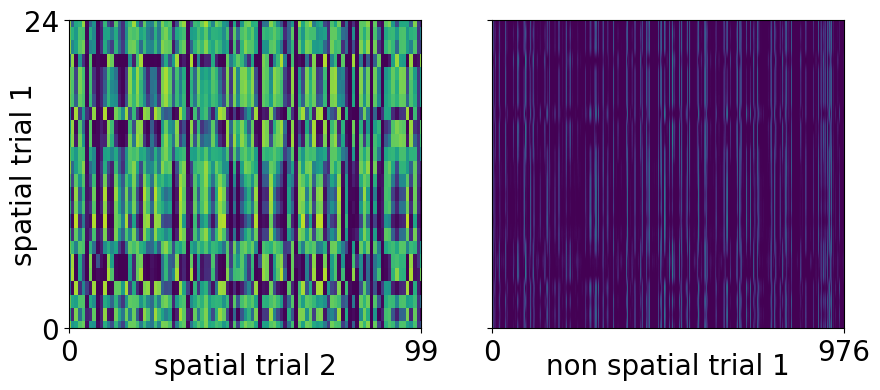

In [23]:
m1 = 1.1
m2 = 0.

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axs[0].imshow(activity_dot_in, aspect='auto', vmax=m1, vmin=m2)
axs[0].set_xlim(0, activity_dot_in.shape[1]-1)
axs[0].set_xlabel('spatial trial 2', fontsize=fontsize, labelpad=-10)
axs[0].set_xticks([0, activity_dot_in.shape[1]-1], [0, activity_dot_in.shape[1]],
                 fontsize=fontsize)
axs[0].set_ylim(0, activity_dot_in.shape[0]-1)
axs[0].set_ylabel('spatial trial 1', fontsize=fontsize, labelpad=-10)
axs[0].set_yticks([0, activity_dot_in.shape[0]-1], [0, activity_dot_in.shape[0]],
                 fontsize=fontsize)

axs[1].imshow(activity_dot_out, aspect='auto', vmax=m1, vmin=m2)
axs[1].set_xlim(0, activity_dot_out.shape[1]-1)
axs[1].set_xlabel('non spatial trial 1', fontsize=fontsize, labelpad=-10)
axs[1].set_xticks([0, activity_dot_out.shape[1]-1], [0, activity_dot_out.shape[1]],
                 fontsize=fontsize)
axs[1].set_ylim(0, activity_dot_out.shape[0]-1)
axs[1].set_yticks([0, activity_dot_out.shape[0]-1], [0, activity_dot_out.shape[0]],
                 fontsize=fontsize)
plt.show()